# Libraries 

In [1]:
import math
import re

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

/home/danit/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Helper functions

# Data loading

In [2]:
train_word2vec = pickle.load(open('train_word2vec.pkl', 'rb'))
train_tfidf = pickle.load(open('train_tfiidf.pkl', 'rb'))

test_word2vec = pickle.load(open('test_word2vec.pkl', 'rb'))
test_tfidf = pickle.load(open('test_tfiidf.pkl', 'rb'))

train_label = pickle.load(open('train_label.pkl', 'rb'))
test_label = pickle.load(open('test_label.pkl', 'rb'))

# Supervised modeling

## Models with TF-IDF vectors

### Gradient Boosting

In [3]:
gb_clf = CatBoostClassifier()
gb_clf.fit(train_tfidf.toarray(), train_label)

predicted = gb_clf.predict(test_tfidf.toarray())

print('Accuracy', gb_clf.score(test_tfidf.toarray(),test_label))
print('Metrics', metrics.classification_report(predicted,test_label))

Accuracy 0.954125068904269
Metrics              precision    recall  f1-score   support

        0.0       0.99      0.95      0.97     11850
        1.0       0.88      0.96      0.92      4477

avg / total       0.96      0.95      0.95     16327



### Random Forest

In [4]:
rf_clf = RandomForestClassifier()
rf_clf.fit(train_tfidf, train_label)

predicted = rf_clf.predict(test_tfidf)

print('Accuracy', rf_clf.score(test_tfidf.toarray(),test_label))
print('Metrics', metrics.classification_report(predicted,test_label))

Accuracy 0.9553500336865315
Metrics              precision    recall  f1-score   support

          0       0.98      0.96      0.97     11658
          1       0.90      0.95      0.92      4669

avg / total       0.96      0.96      0.96     16327



In [5]:
pca = TruncatedSVD(2)
pca_2d = pca.fit_transform(test_tfidf)

In [6]:
plt.figure(figsize=(24,20))

for i in range(0, pca_2d.shape[0]):
    if predicted[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='blue', marker='*',s=200)
    elif predicted[i] == 1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='green',marker='o',s=200)

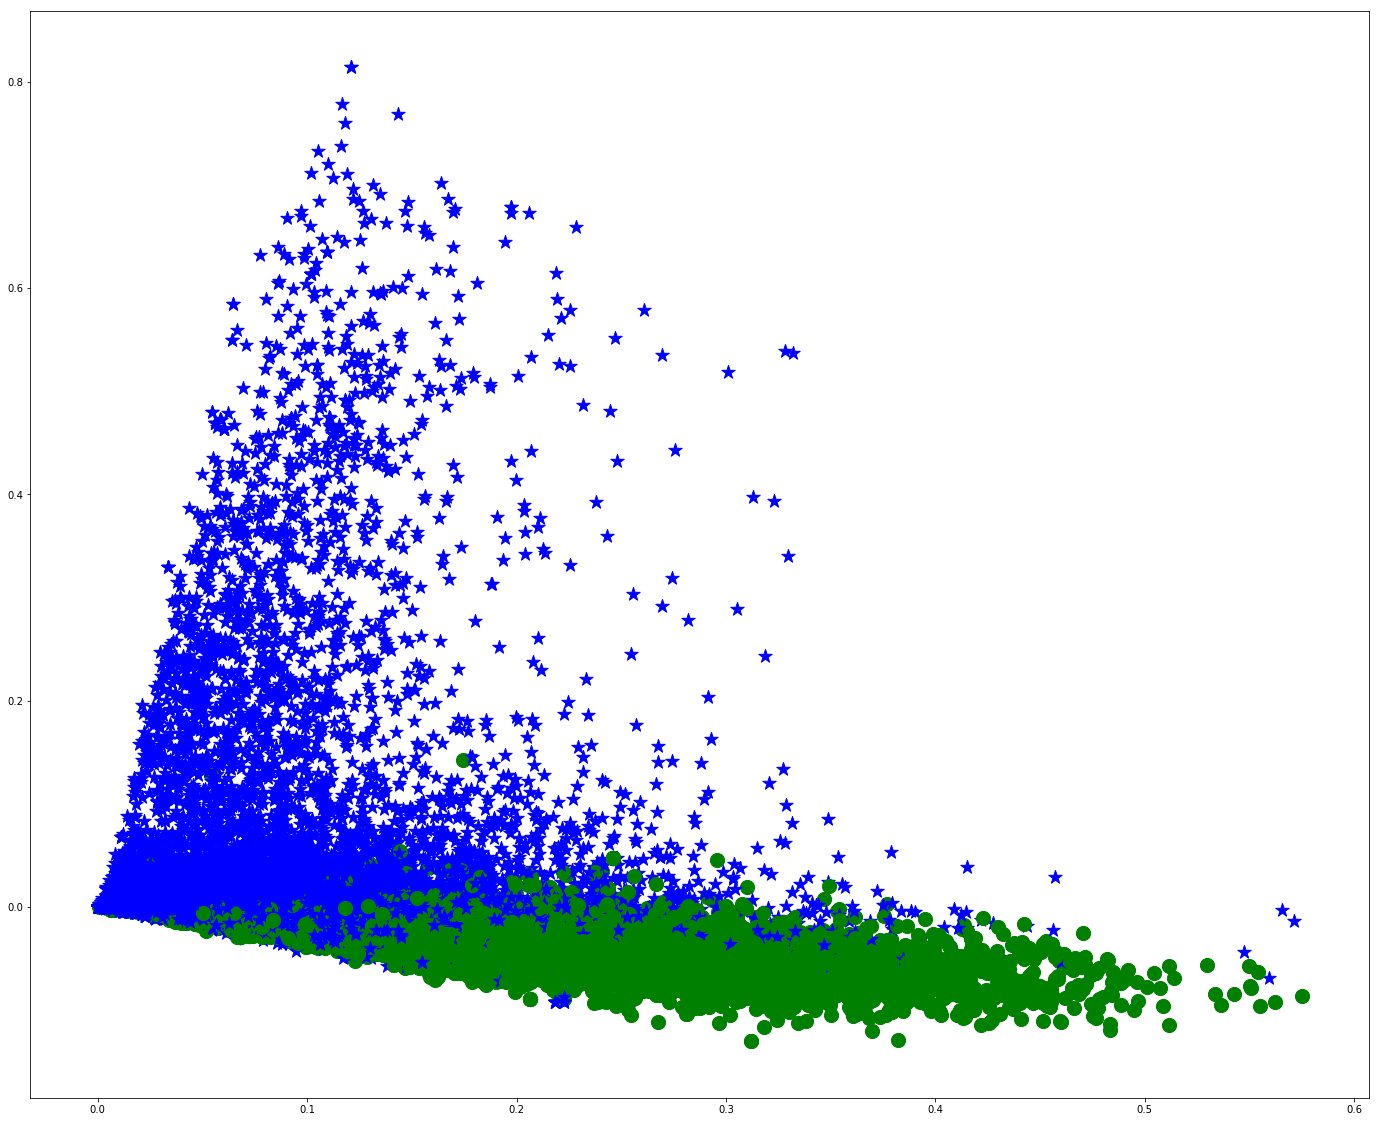

In [7]:
plt.show()

## Models with word2vec vectors

### Gradient Boosting

In [8]:
gb_clf = CatBoostClassifier()
gb_clf.fit(train_word2vec, train_label)

predicted = gb_clf.predict(test_word2vec)

print('Accuracy', gb_clf.score(test_word2vec,test_label))
print('Metrics', metrics.classification_report(predicted,test_label))

Accuracy 0.9056777117657867
Metrics              precision    recall  f1-score   support

        0.0       0.95      0.92      0.93     11811
        1.0       0.80      0.87      0.84      4516

avg / total       0.91      0.91      0.91     16327



In [9]:
pca = TruncatedSVD(2)
pca_2d = pca.fit_transform(test_word2vec)

In [10]:
plt.figure(figsize=(24,20))

for i in range(0, pca_2d.shape[0]):
    if predicted[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='blue', marker='*',s=200)
    elif predicted[i] == 1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='green',marker='o',s=200)

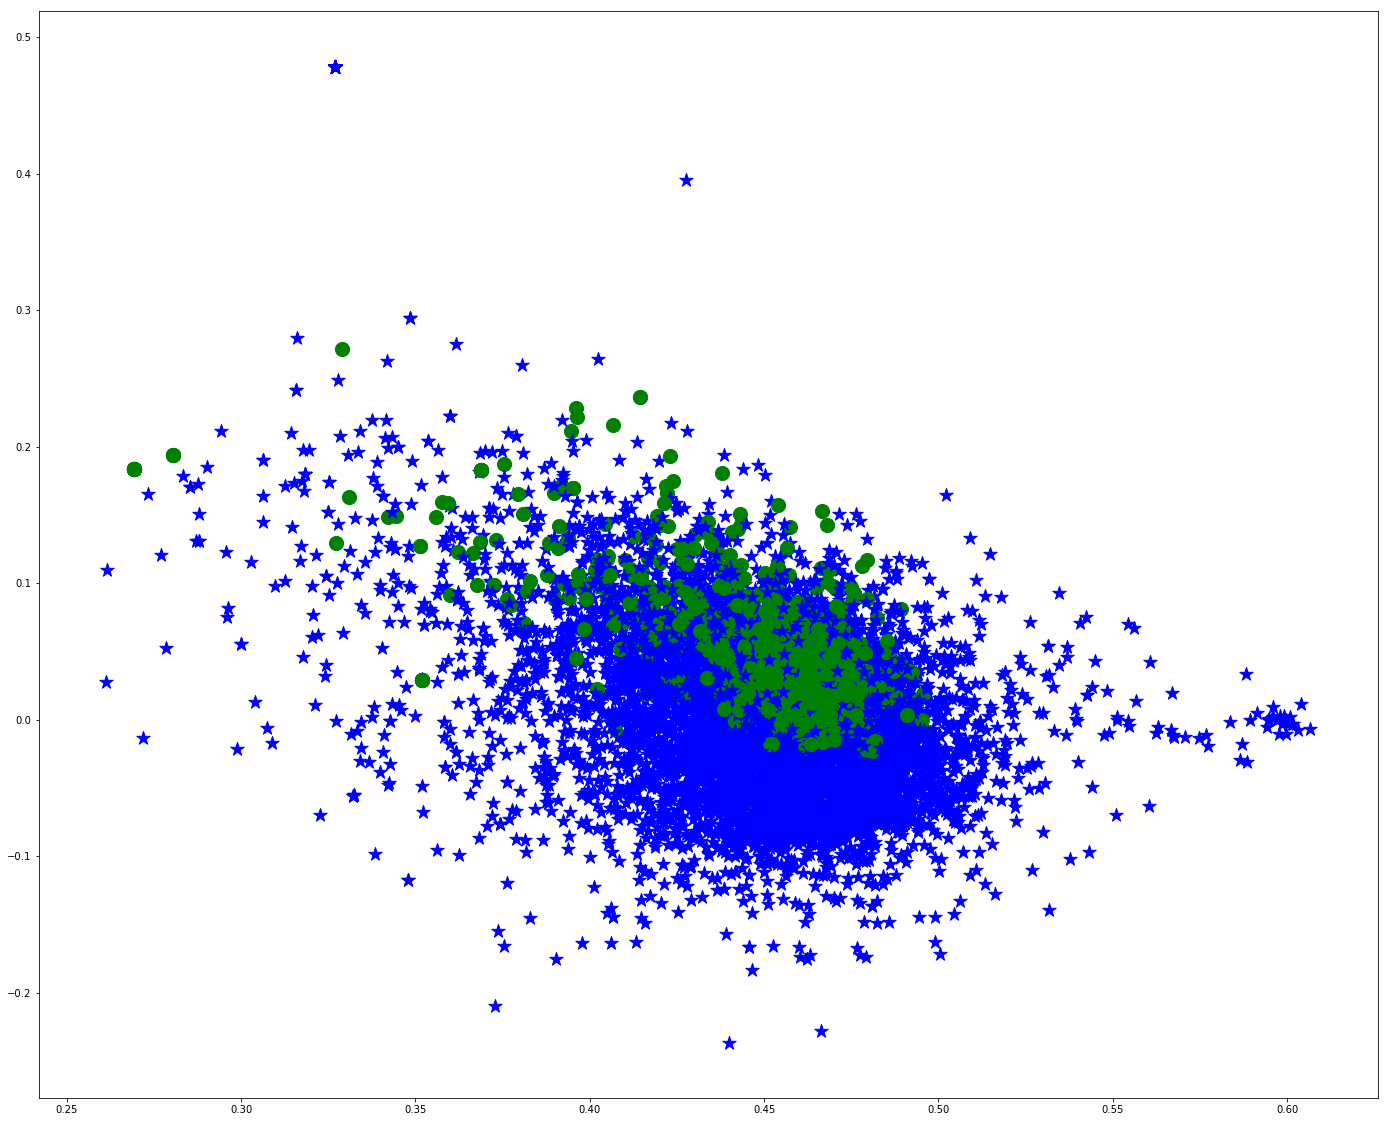

In [11]:
plt.show()

### Random Forest

In [12]:
rf_clf = RandomForestClassifier()
rf_clf.fit(train_word2vec, train_label)

predicted = rf_clf.predict(test_word2vec)

print('Accuracy', rf_clf.score(test_word2vec,test_label))
print('Metrics', metrics.classification_report(predicted,test_label))

Accuracy 0.895081766399216
Metrics              precision    recall  f1-score   support

          0       0.96      0.90      0.93     12212
          1       0.75      0.89      0.81      4115

avg / total       0.91      0.90      0.90     16327



### AUC-ROC score of the best algorithm 

In [14]:
classifier = RandomForestClassifier()

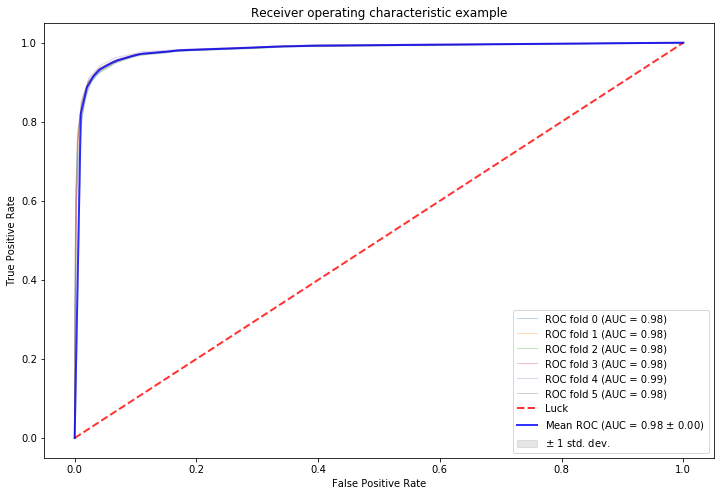

In [15]:
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
X_w2v = train_tfidf.toarray()
y_w2v = np.array(train_label)

plt.figure(figsize=(12,8))
for train, test in cv.split(X_w2v, y_w2v):
    probas_ = classifier.fit(X_w2v[train], y_w2v[train]).predict_proba(X_w2v[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_w2v[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()